In [7]:
# Install
!pip install -q biopython transformers datasets huggingface_hub accelerate

In [8]:
!pip install umap-learn

In [9]:
# Imports
import transformers
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification, EarlyStoppingCallback, pipeline, AutoModel
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm

In [10]:
import sklearn
import sklearn.datasets
import sklearn.manifold
import sklearn.decomposition
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.cluster
import sklearn.mixture
import sklearn.model_selection
from scipy.cluster.hierarchy import dendrogram
import matplotlib
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import math
import umap

In [11]:
# set folder path - should be the same as in fine_tune DHS_NT_model.iypnb

folder_path = '/content/drive/My Drive/TechnicalTestWangLab/'
figure_path = folder_path + 'figures/'

In [12]:

# Mount your Google Drive
drive.mount('/content/drive')

# Change directory to the desired location within your Google Drive
os.chdir(folder_path)

dir_path = os.getcwd()

dataset_path = dir_path + '/'+ 'DHS_NT_datasets'

# Load the datasets from the saved location
datasets = DatasetDict.load_from_disk(dataset_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
model_name = "./finetuned-DHS-nucleotide-transformer-model"
tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, local_files_only=True, trust_remote_code=True).to('cuda')

Some weights of EsmModel were not initialized from the model checkpoint at ./finetuned-DHS-nucleotide-transformer-model and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(f"number of GPU: {n_gpu}")
print(f"torch version with cuda: {torch.version.cuda}")
print(f"transformer version: {transformers.__version__}")
print(f"torch version: {torch.__version__}")
#model.to(device)

number of GPU: 1
torch version with cuda: 12.1
transformer version: 4.41.2
torch version: 2.3.0+cu121


In [15]:
def tokenize_function(examples):
    outputs = tokenizer(examples["sequence"])
    return outputs

In [16]:
# set up a feature extraction pipeline that will take a text
# and generate the features for this text using the BERT model and tokenizer we loaded.
feature_extractor = pipeline('feature-extraction', model=model, tokenizer=tokenizer, device=0)

In [17]:
# Function to extract embeddings
def extract_embeddings(dataset, feature_extractor):
    embeddings = []
    for item in tqdm(dataset):
        text = item['sequence']
        #with torch.no_grad():
        result = feature_extractor(text, return_tensors="pt", batch_size=32)
        # Using mean pooling
        mean_embedding = result[0].numpy().mean(axis=0)
        embeddings.append(mean_embedding)
    return np.array(embeddings).squeeze()

In [18]:
# Extract embeddings from Test set DNA sequences
test_embeddings = extract_embeddings(datasets["test"], feature_extractor)

100%|██████████| 9575/9575 [03:15<00:00, 49.01it/s]


In [19]:
test_embeddings.shape

(9575, 1280)

In [20]:
# Example usage
label_mapping = {
    'K562_ENCLB843GMH': 0,
    'hESCT0_ENCLB449ZZZ': 1,
    'HepG2_ENCLB029COU': 2,
    'GM12878_ENCLB441ZZZ': 3
}

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm

def make_scatterplot(X_pca, y, h_pc=0, v_pc=1, percent_ve=None, algo="pca", centers=None, equal_aspect=False, label_mapping=None, save_path=None):
    assert X_pca.shape[1] > max(h_pc, v_pc)
    if algo != "pca":
        assert percent_ve is None

    # Associate each label with a color
    if y is not None:
        unique_labels = np.unique(y)
        num_classes = len(unique_labels)
        cmap = matplotlib.cm.gist_rainbow(np.linspace(0, 1, num_classes))
        if num_classes == 2:
            cmap = matplotlib.cm.gist_rainbow(np.linspace(0, 0.5, num_classes))

        color_dict = {label: color for label, color in zip(unique_labels, cmap)}
        y_color = np.array([color_dict[label] for label in y])
    else:
        y_color = None

    fig, ax = plt.subplots()
    scatter = ax.scatter(X_pca[:, h_pc], X_pca[:, v_pc], c=y_color, s=(matplotlib.rcParams['lines.markersize'] ** 2) / 3)

    # Set labels for axes
    if algo == "pca":
        xlabel = f"PC{h_pc + 1}"
    elif algo == "tsne":
        xlabel = f"t-SNE dim {h_pc + 1}"
    elif algo == "umap":
        xlabel = f"UMAP dim {h_pc + 1}"
    elif algo == "data":
        xlabel = f"data dim {h_pc + 1}"

    if percent_ve is not None:
        xlabel += f" ({100 * percent_ve[h_pc]:.2f}%)"

    ax.set_xlabel(xlabel)

    if algo == "pca":
        ylabel = f"PC{v_pc + 1}"
    elif algo == "tsne":
        ylabel = f"t-SNE dim {v_pc + 1}"
    elif algo == "umap":
        ylabel = f"UMAP dim {v_pc + 1}"
    elif algo == "data":
        ylabel = f"data dim {v_pc + 1}"

    if percent_ve is not None:
        ylabel += f" ({100 * percent_ve[v_pc]:.2f}%)"

    ax.set_ylabel(ylabel)

    title = f"{algo.upper()} of Cell Type DNA sequence Embeddings - Test Set"
    ax.set_title(title)

    if centers is not None:
        for c in range(centers.shape[0]):
            ax.plot(centers[c][h_pc], centers[c][v_pc], marker="x", color="black")

    if equal_aspect:
        ax.set_aspect("equal", "datalim")

    # Add legend
    if label_mapping is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[label], markersize=10)
                   for label in unique_labels]
        labels = [name for name, label in label_mapping.items() if label in unique_labels]
        ax.legend(handles, labels, title="Labels", loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0.5)


     # Save the plot if save_path is provided
    if save_path is not None:
        save_file = f"{save_path}/{algo.upper()}_Plot.png"
        plt.savefig(save_file, bbox_inches='tight')


    fig.show()

In [22]:
pca = sklearn.decomposition.PCA(n_components=4)
X_pca = pca.fit_transform(test_embeddings)
print(X_pca.shape) # 2 PCs
percent_ve = pca.explained_variance_ratio_
print(percent_ve)

(9575, 4)
[0.30357563 0.25053814 0.16893265 0.03193996]


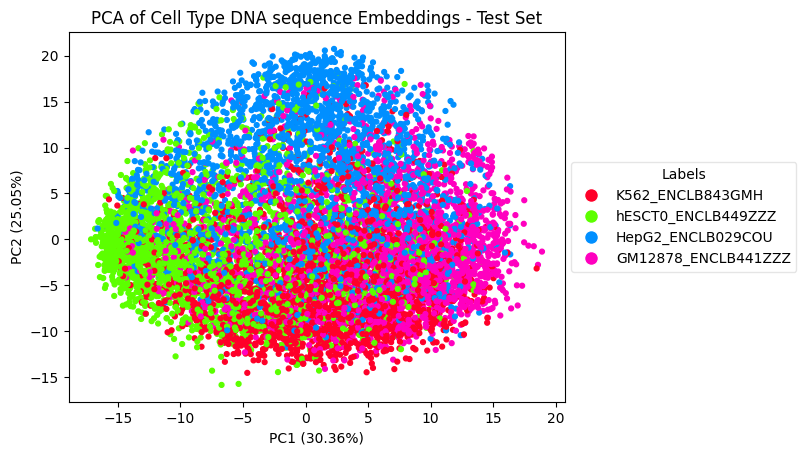

In [23]:
make_scatterplot(X_pca,datasets["test"]["labels"],h_pc=0,v_pc=1,percent_ve=percent_ve,algo="pca", label_mapping=label_mapping, save_path=figure_path)

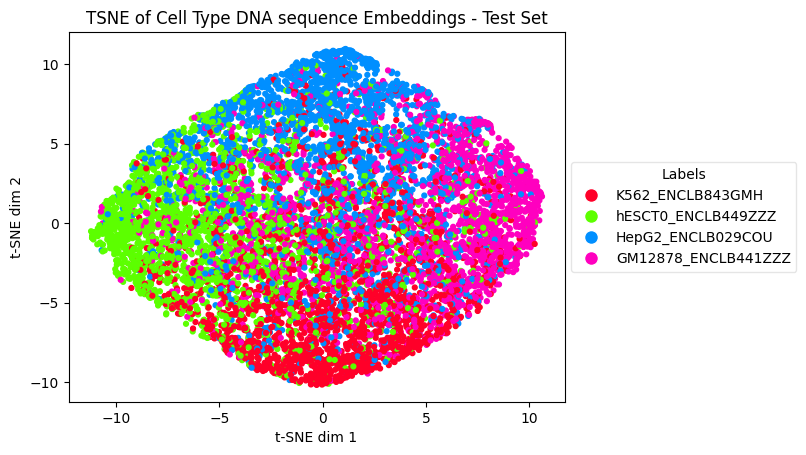

In [24]:
# perplexity == 30, init == "pca"
tsne = sklearn.manifold.TSNE(n_components=2,perplexity=30.,init="pca",method="barnes_hut",learning_rate="auto",n_iter=300)
X_tsne = tsne.fit_transform(test_embeddings)
make_scatterplot(X_tsne,datasets["test"]["labels"],h_pc=0,v_pc=1,algo="tsne", label_mapping=label_mapping, save_path=figure_path)

(9575, 2)


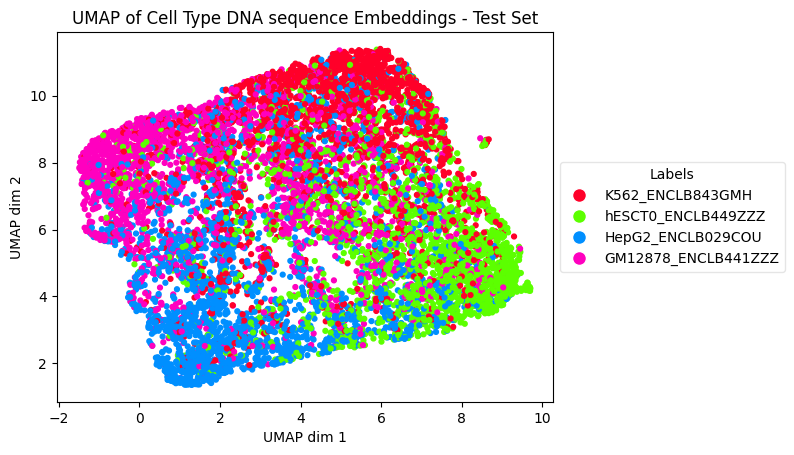

In [26]:
um = umap.umap_.UMAP(n_components=2,n_neighbors=15,min_dist=.1,metric="euclidean",init="spectral",n_epochs=300)
X_um = um.fit_transform(test_embeddings)
print(X_um.shape)
make_scatterplot(X_um,datasets["test"]["labels"],h_pc=0,v_pc=1,algo="umap", label_mapping=label_mapping, save_path=figure_path)